[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.85 s, sys: 1.8 s, total: 6.65 s
Wall time: 8.24 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:25<00:00, 26.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 15.5 s, sys: 5.42 s, total: 20.9 s
Wall time: 26.6 s
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:19<00:00,  7.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.6 s, sys: 2.31 s, total: 11.9 s
Wall time: 21.8 s


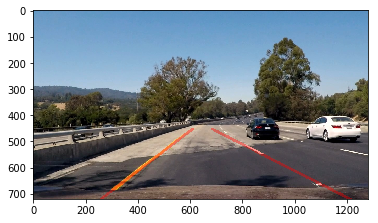

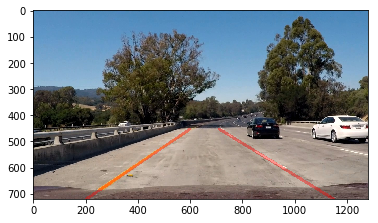

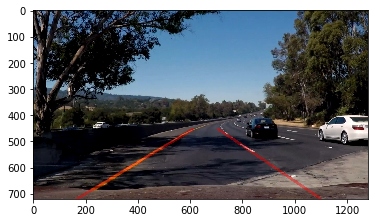

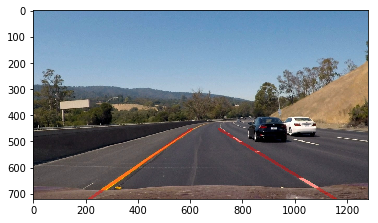

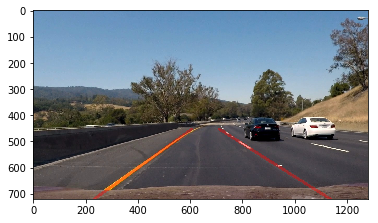

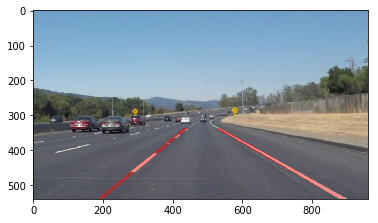

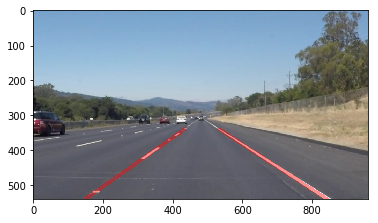

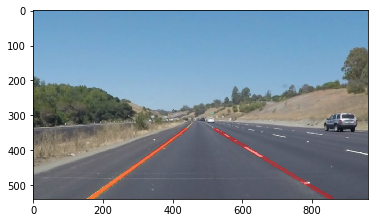

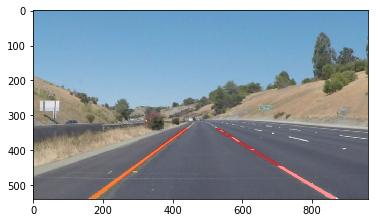

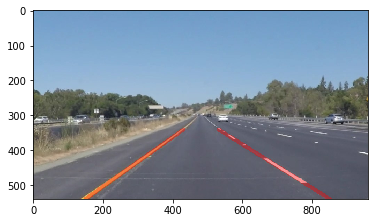

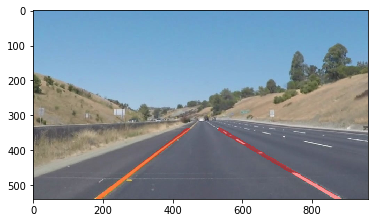

In [1]:
# Finding Lane Lines

# import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math 
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from decimal import *
getcontext().prec = 8

# mask for seperating yellow and white
# REF: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
def select_white_yellow(image):
    
    # Convert BGR to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    cv2.medianBlur(hls,3)

    # define range of yellow and white color in HLS
    lower_yellow = np.array([0,130,0]) #10,0,200
    upper_yellow = np.array([100,255,255])  #100,220,255
       
    # Threshold the HLS image to get only yellow and white colors
    mask_yellow = cv2.inRange(hls, lower_yellow, upper_yellow)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask=mask_yellow)
    
    return res

# calculate average slope and intercept of a group of lines (seperate left and right)
def findAvgLaneLines(lines, divider):
    m_left = []
    b_left = []
    l_left = []
    m_right =  []
    b_right = []
    l_right = []
    for line in lines:
            for x1,y1,x2,y2 in line:
                if (x2 - x1) != 0: # Protect for undefined function
                    m = (y2 - y1) / (x2 - x1)
                    b = y1 - m*x1
                    l = math.sqrt(math.pow((y2 - y1), 2) + math.pow((x2 - x1), 2))
                    if (abs(m) < 0.5): # Remove lines close to horizontal
                        continue
                    if ((x1 < divider) and (x2 < divider)): # Seperate into left and right by divider
                        m_left.append(m) 
                        b_left.append(b)
                        l_left.append(l)
                    else:
                        m_right.append(m)
                        b_right.append(b)
                        l_right.append(l)
    # REF: http://stackoverflow.com/questions/29330792/python-weighted-averaging-a-list
    if ((len(l_left) > 0) and (len(l_right) > 0)): # Protect for undefined function
        avg_m_left = Decimal(sum(m_left[g] * l_left[g] for g in range(len(l_left))) / sum(l_left))
        avg_b_left = Decimal(sum(b_left[g] * l_left[g] for g in range(len(l_left))) / sum(l_left))
        avg_m_right = Decimal(sum(m_right[g] * l_right[g] for g in range(len(l_right))) / sum(l_right))
        avg_b_right = Decimal(sum(b_right[g] * l_right[g] for g in range(len(l_right))) / sum(l_right))
    else:
        avg_m_left = None
        avg_b_left = None
        avg_m_right = None
        avg_b_right = None 
    
    avg_lines = ((avg_m_left, avg_b_left), (avg_m_right, avg_b_right))
    return avg_lines

# take in boundries, y1 (top) and y2 (bottom), and line m, b 
# result is the points of line that cross through y(top) and y (bottom)
def points_from_line(y1,y2,line):
    
    m, b = line
    if m is None or m == 0: # Protect for line if is None
        return None
    y1 = Decimal(y1)
    y2 = Decimal(y2)
    
    x1 = int((y1 - b)/m)
    x2 = int((y2 - b)/m)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

# parameters for Canny edge detection
Canny_low_threshold = 50
Canny_high_threshold = 200

# parameters for Hough Transform
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 8  # minimum number of pixels making up a line
max_line_gap = 12   # maximum gap in pixels between connectable line segments

# process the image and overlay lane lines
def process_image(image):
    # pull out white and yellow colors from image
    white_yellow = select_white_yellow(image)
    
    # REF: Course Material for Udacity Car ND https://www.udacity.com/drive
    
    # change image to greyscale
    gray = cv2.cvtColor(white_yellow,cv2.COLOR_RGB2GRAY)

    # define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # use defined parameters for Canny and apply
    edges = cv2.Canny(blur_gray, Canny_low_threshold, Canny_high_threshold)

    # create masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # define four sided polygon to mask
    imshape = image.shape
    left_bottom = (np.int(imshape[1]*0.15),imshape[0])
    left_top = (np.int(0.4*imshape[1]), np.int(0.65*imshape[0]))
    right_top = (np.int(0.6*imshape[1]), np.int(0.65*imshape[0]))
    right_bottom = (np.int(imshape[1]-imshape[1]*0.05),imshape[0])
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # run Hough on edge detected image
    # output "lines" is an array containing endpoints of detected line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # iterate over the output "lines" and draw lines on a blank image (intermediate step)
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#     plt.figure()
#     plt.imshow(line_image)       
    
    # find average slope and y-intercept for lines
    divider = (right_top[0] - left_top[0]) / 2 + left_top[0]
    avg_lane_lines = findAvgLaneLines(lines, divider) # ([[m_right, b_right], [m_left, b_left]])

    # define the image for average lines and draw the average lines 
    overlay = image.copy()
    ybottom = imshape[0]
    ytop = np.int(0.63*imshape[0])
    points_left = points_from_line(ybottom, ytop, avg_lane_lines[0]) #((x1, y1), (x2, y2))
    points_right = points_from_line(ybottom, ytop, avg_lane_lines[1]) #((x1, y1), (x2, y2))
    if points_left is not None:
        cv2.line(overlay,points_left[0],points_left[1],(255,0,0),10)
    if points_right is not None:
        cv2.line(overlay,points_right[0],points_right[1],(255,0,0),10)

    # overlay the average lines over the original image with a transparent red color
    output = image.copy()
    processed = cv2.addWeighted(overlay, 0.4, output, 0.6, 0)
    return processed

# process test images
for filename in os.listdir("test_images/"):
    if filename.endswith(".jpg"): 
        # identify the image
        image = mpimg.imread(os.path.join("test_images/", filename))
        output = process_image(image)
        
        plt.figure()
        plt.imshow(output)
        
        # save the file as overlay
        mpimg.imsave((os.path.join("test_images/found_lane_lines/", filename)),output)

# process white.mp4 video
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# process yellow.mp4 video
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

# process challenge.mp4 video
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))